<a href="https://colab.research.google.com/github/ahlraf/ML-projects/blob/main/solving_GLUE_tasks_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# model to preprocess text before fine-tuning BERT depends on tensorflow/text
! pip install -q -U tensorflow-text

In [2]:
# AdamW optimizer from tensorflow/models to fine-tune BERT
! pip install -q -U tf-models-official

In [3]:
! pip install -U tfds-nightly

Requirement already up-to-date: tfds-nightly in /usr/local/lib/python3.7/dist-packages (4.2.0.dev202105010106)


In [4]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text # dependency of the preprocessing model
import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

In [5]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"] = "UNCOMPRESSED"

#### Connecting to the TPU worker
Changes TensorFlow's default device to the CPU device on the TPU worker.
Also defines TPU distribution strategy that we use to distribute model training onto 8 separate TPU cores available.

In [6]:
import os

if os.environ['COLAB_TPU_ADDR']:
  cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
  strategy = tf.distribute.TPUStrategy(cluster_resolver)
  print('Using TPU')

elif tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')

else:
  raise ValueError('Running on CPU is not recommended.')

Using TPU


Using BERT-base. 

In [7]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Preprocess text
Preprocess as part of input pipeline for training using Dataset.map, then merge it into the model that gets exported for inference. This way both training and inference can work from raw text inputs. TPU required numeric inputs.

Can help performance to have preprocessing done asynchronously in an input pipeline.

In [8]:
bert_preprocess = hub.load(tfhub_handle_preprocess)
tok = bert_preprocess.tokenize(tf.constant(['Hello TensorFlow!']))
print(tok)


<tf.RaggedTensor [[[7592], [23435, 12314], [999]]]>


.bert_pack_inputs(tensors, seq_length) - takes list of tokens and seq length: packs inputs to create a dict of tensors in format req by BERT model

In [9]:
text_preprocessed = bert_preprocess.bert_pack_inputs([tok, tok], tf.constant(20))

print('Shape Word Ids:', text_preprocessed['input_word_ids'].shape)
print('Word Ids:', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask:', text_preprocessed['input_mask'].shape)
print('Input Mask:', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids:', text_preprocessed['input_type_ids'].shape)
print('Type Ids:', text_preprocessed['input_type_ids'][0, :16])

Shape Word Ids: (1, 20)
Word Ids: tf.Tensor(
[  101  7592 23435 12314   999   102  7592 23435 12314   999   102     0
     0     0     0     0], shape=(16,), dtype=int32)
Shape Mask: (1, 20)
Input Mask: tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids: (1, 20)
Type Ids: tf.Tensor([0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0], shape=(16,), dtype=int32)


- input_mask = allows model to differentiate between content and padding. Same shape as input_word_ids, contains 1 everywhere input_word_ids is not padding.
- input_type_ids - inside non-padding region contains 0 or 1 indicating which sentence the token is a part of.


**Preprocessing model**: takes strings as input, returns properly formatted objects that can be passed to BERT.<br>


BERT adds "position embedding" to token embedding of each input, and these come from fixed size lookup table. This imposes a max seq length of 512 (also practical limit due to quadratic growth.)

In [10]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """
  Returns model mapping string features to BERT inputs.

  Args:
  sentence_features: list with names of string-values features.
  seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
  A Keras Model that can be called on a list or dict of string Tensors
  (with the order or names respectively given by sentence_features) and
  returns a dict of tensors for input to BERT.
  """

  input_segments = [
                    tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
                    for ft in sentence_features
  ]

  # tokenize the text to word pieces
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenize')
  segments = [tokenizer(s) for s in input_segments]

  # optional: trim segments to fit seq_length
  # for simple cases, skip and let the next step apply a default truncation
  # to approximately equal lengths
  truncated_segments = segments

  # pack inputs: details (start/ end token ids, dict of output tensors) -
  # are model dependent, so this gets loaded from SavedModel
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)


In [13]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['some random test sentence']),
             np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print("Keys:", list(text_preprocessed.keys()))
print("Shape Word Ids:", text_preprocessed['input_word_ids'].shape)
print("Word Ids:", text_preprocessed['input_word_ids'][0, :16])
print("Shape Mask:", text_preprocessed['input_mask'].shape)
print("Input Mask:", text_preprocessed['input_mask'][0, :16])
print("Shape Type Ids:", text_preprocessed['input_type_ids'].shape)
print("Type Ids:", text_preprocessed['input_type_ids'][0, :16])


Keys: ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids: (1, 128)
Word Ids: tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask: (1, 128)
Input Mask: tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids: (1, 128)
Type Ids: tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


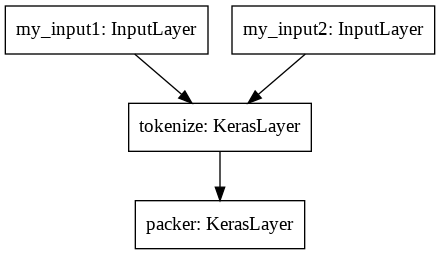

In [14]:
tf.keras.utils.plot_model(test_preprocess_model)

To apply preprocessing to all inputs, use map function, then cache result for performance.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

def load_dataset_from_tfds(in_memory_ds, info, split, batch_size, bert_preprocess_model):
  is_training = split.startswith('train')
  dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
  num_examples = info.splits[split].num_examples

  if is_training:
    dataset = dataset.shuffle(num_examples)
    dataset = dataset.repeat()

  dataset = dataset.batch(batch_size)
  dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
  dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
  
  return dataset, num_examples

### Define model
Define model for sentence/ sentence pair classification by feeding preprocessed inputs through BERT encoder, putting linear classifier on top, using dropout for regularization.

In [17]:
def build_classifier_model(num_classes):
  inputs = dict(
      input_word_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
      input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32),
  )
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='encoder')
  net = encoder(inputs)['pooled_output']
  net = tf.keras.layers.Dropout(rate=0.1)(net)
  net = tf.keras.layers.Dense(num_classes, activation=None, name='classifier')(net)
  return tf.keras.Model(inputs, net, name="prediction")

Running on preprocessed inputs:

In [19]:
test_classifier_model = build_classifier_model(2)
bert_raw_result = test_classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.7828614 0.7210064]], shape=(1, 2), dtype=float32)


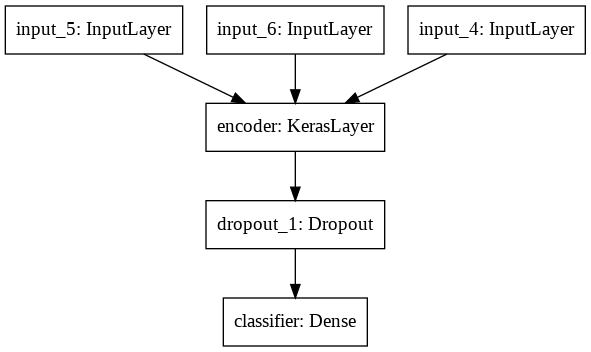

In [21]:
tf.keras.utils.plot_model(test_classifier_model)

### GLUE task
for TF dataset - CoLa

In [22]:
tfds_name = 'glue/cola' 

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'
if tfds_name == 'glue/mnli':
  validation_split = 'validation_matched'
  test_split = 'test_matched'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(5):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

Using glue/cola from TFDS
This dataset has 10657 examples
Number of classes: 2
Features ['sentence']
Splits ['test', 'train', 'validation']


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/cola/1.0.0. Subsequent calls will reuse this data.
Here are some sample rows from glue/cola dataset
['unacceptable', 'acceptable']

sample row 1
b'It is this hat that it is certain that he was wearing.'
label: 1 (acceptable)

sample row 2
b'Her efficient looking up of the answer pleased the boss.'
label: 1 (acceptable)

sample row 3
b'Both the workers will wear carnations.'
label: 1 (acceptable)

sample row 4
b'John enjoyed drawing trees for his syntax homework.'
label: 1 (acceptable)

sample row 5
b'We consider Leslie rather foolish, and Lou a complete idiot.'
label: 1 (acceptable)



In [24]:
# determine the problem type (classification/ regression) 
# and appropriate loss function for training
def get_configuration(glue_task):

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  if glue_task=="glue/cola":
    metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
  else:
    metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)

  return metrics, loss

### Training model

#### Distribution
Create and compile main Keras model within scope of TPU distribution strategy. Preprocessign runs on CPU of worker host. Keras model for preprocessing, mapped training and validation datasets are built outside the distribution strategy scope. Call to Model.fit() distributes passed in dataset to model replicas.

Single TPU worker host - has resource objects needs for tokenization. To scale up to multiple workers, use Strategy.experimental_distribute_datasets_from_function.

### Optimizer
Fine-tuning follows optimizer setup from BERT pretraing. Uses AdamW optimizer with linear decay of notional initia learning rate, prefixed with linear warmup phase over first 10% of training steps. Initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [26]:
epochs = 3
batch_size = 32
init_lr = 2e-5

print(f'Fine tuning {tfhub_handle_encoder} model')
bert_preprocess_model = make_bert_preprocess_model(sentence_features)


with strategy.scope():

  # metrics have to be created inside the strategy scope
  metrics, loss = get_configuration(tfds_name)

  train_dataset, train_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model
  )
  steps_per_epoch = train_data_size // batch_size
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = num_train_steps // 10

  validation_dataset, validation_data_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, validation_split, batch_size, bert_preprocess_model
  )
  validation_steps = validation_data_size // batch_size

  classifier_model = build_classifier_model(num_classes)

  optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw'
  )

  classifier_model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  classifier_model.fit(
      x=train_dataset,
      validation_data=validation_dataset,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      validation_steps=validation_steps
  )

Fine tuning https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3 model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:1", shape=(None,), dtype=int32), values=Tensor("clip_by_global_norm/clip_by_global_norm/_0:0", dtype=float32), dense_shape=Tensor("AdamWeightDecay/gradients/StatefulPartitionedCall:2", shape=(None,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)


267/267 [==============================] - 91s 101ms/step - loss: 0.6093 - MatthewsCorrelationCoefficient: 0.5936 - val_loss: 0.4476 - val_MatthewsCorrelationCoefficient: 0.5871
Epoch 2/3
267/267 [==============================] - 22s 83ms/step - loss: 0.3445 - MatthewsCorrelationCoefficient: 0.5921 - val_loss: 0.5357 - val_MatthewsCorrelationCoefficient: 0.5871
Epoch 3/3
267/267 [==============================] - 24s 91ms/step - loss: 0.2277 - MatthewsCorrelationCoefficient: 0.5941 - val_loss: 0.6217 - val_MatthewsCorrelationCoefficient: 0.5871


### Exporting for inference
Preprocessing needs to be part of the model (no longer a separate input queue as for training data). 

In [27]:
main_save_path = './my_models'
bert_type = tfhub_handle_encoder.split('/')[-2]
saved_model_name = f'{tfds_name.replace("/","_")}_{bert_type}'

saved_model_path = os.path.join(main_save_path, saved_model_name)

preprocess_inputs = bert_preprocess_model.inputs
bert_encoder_inputs = bert_preprocess_model(preprocess_inputs)
bert_outputs = classifier_model(bert_encoder_inputs)
model_for_export = tf.keras.Model(preprocess_inputs, bert_outputs)

print('Saving', saved_model_path)

save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
model_for_export.save(saved_model_path, include_optimizer=False, options=save_options)

Saving ./my_models/glue_cola_bert_en_uncased_L-12_H-768_A-12


### Testing the model

In [28]:
with tf.device('/job:localhost'):
  reloaded_model = tf.saved_model.load(saved_model_path)

In [29]:
def prepare(record):
  model_inputs = [[record[ft]] for ft in sentence_features]
  return model_inputs


def prepare_serving(record):
  model_inputs = {ft: record[ft] for ft in sentence_features}
  return model_inputs


def print_bert_results(test, bert_result, dataset_name):

  bert_result_class = tf.argmax(bert_result, axis=1)[0]

  if dataset_name == 'glue/cola':
    print('sentence:', test[0].numpy())
    if bert_result_class == 1:
      print('This sentence is acceptable')
    else:
      print('This sentence is unacceptable')

  elif dataset_name == 'glue/sst2':
    print('sentence:', test[0])
    if bert_result_class == 1:
      print('This sentence has POSITIVE sentiment')
    else:
      print('This sentence has NEGATIVE sentiment')

  elif dataset_name == 'glue/mrpc':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Are a paraphrase')
    else:
      print('Are NOT a paraphrase')

  elif dataset_name == 'glue/qqp':
    print('question1:', test[0])
    print('question2:', test[1])
    if bert_result_class == 1:
      print('Questions are similar')
    else:
      print('Questions are NOT similar')

  elif dataset_name == 'glue/mnli':
    print('premise   :', test[0])
    print('hypothesis:', test[1])
    if bert_result_class == 1:
      print('This premise is NEUTRAL to the hypothesis')
    elif bert_result_class == 2:
      print('This premise CONTRADICTS the hypothesis')
    else:
      print('This premise ENTAILS the hypothesis')

  elif dataset_name == 'glue/qnli':
    print('question:', test[0])
    print('sentence:', test[1])
    if bert_result_class == 1:
      print('The question is NOT answerable by the sentence')
    else:
      print('The question is answerable by the sentence')

  elif dataset_name == 'glue/rte':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Sentence1 DOES NOT entails sentence2')
    else:
      print('Sentence1 entails sentence2')

  elif dataset_name == 'glue/wnli':
    print('sentence1:', test[0])
    print('sentence2:', test[1])
    if bert_result_class == 1:
      print('Sentence1 DOES NOT entails sentence2')
    else:
      print('Sentence1 entails sentence2')

  print('BERT raw results:', bert_result[0])
  print()

Test:

In [30]:
with tf.device('/job:localhost'):
  test_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[test_split])
  for test_row in test_dataset.shuffle(1000).map(prepare).take(5):
    if len(sentence_features) == 1:
      result = reloaded_model(test_row[0])
    else:
      result = reloaded_model(list(test_row))

    print_bert_results(test_row, result, tfds_name)

sentence: [b'The professor was hoping for a strong evidence.']
This sentence is acceptable
BERT raw results: tf.Tensor([-1.8249425  2.287746 ], shape=(2,), dtype=float32)

sentence: [b'Nobody talked to Susan.']
This sentence is acceptable
BERT raw results: tf.Tensor([-2.7531068  2.679773 ], shape=(2,), dtype=float32)

sentence: [b'This girl there will put a picture of Bill on your desk before tomorrow.']
This sentence is unacceptable
BERT raw results: tf.Tensor([ 1.5568863 -0.8419951], shape=(2,), dtype=float32)

sentence: [b'Nobody talked to Susan.']
This sentence is acceptable
BERT raw results: tf.Tensor([-2.753109   2.6797743], shape=(2,), dtype=float32)

sentence: [b'Books were given to no student by any professor.']
This sentence is acceptable
BERT raw results: tf.Tensor([-1.9280787  2.380236 ], shape=(2,), dtype=float32)



In [31]:
# to use on TF serving:
with tf.device('/job:localhost'):
  serving_model = reloaded_model.signatures['serving_default']
  for test_row in test_dataset.shuffle(1000).map(prepare_serving).take(5):
    result = serving_model(**test_row)
    # the 'prediction' key is the classifier's defined model name
    print_bert_results(list(test_row.values()), result['prediction'], tfds_name)

sentence: b'Dumb ideas are put into their heads by TV.'
This sentence is acceptable
BERT raw results: tf.Tensor([-2.7232633  2.6275067], shape=(2,), dtype=float32)

sentence: b'I put the books.'
This sentence is unacceptable
BERT raw results: tf.Tensor([ 0.7314973  -0.76824695], shape=(2,), dtype=float32)

sentence: b'The boy whose playing the piano loudly I disliked was a student.'
This sentence is acceptable
BERT raw results: tf.Tensor([-1.9520731  2.2959723], shape=(2,), dtype=float32)

sentence: b'He taught the children.'
This sentence is acceptable
BERT raw results: tf.Tensor([-3.4086437  3.194252 ], shape=(2,), dtype=float32)

sentence: b"Jack is making the claim you won't need it."
This sentence is unacceptable
BERT raw results: tf.Tensor([0.81196475 0.18874681], shape=(2,), dtype=float32)

